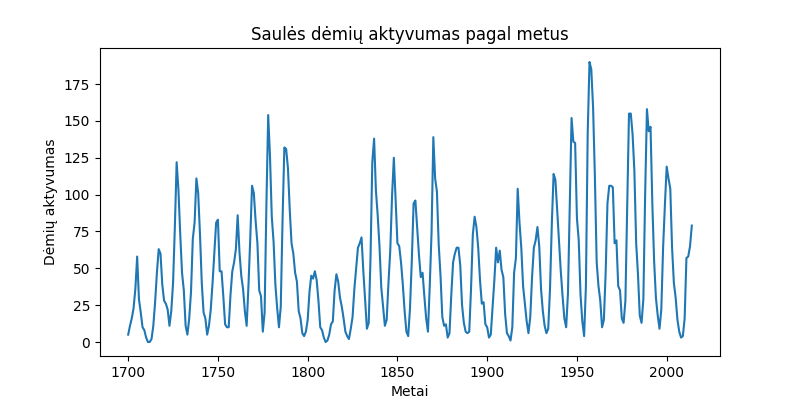

In [192]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from keras import backend as K

data = pd.DataFrame(data=pd.read_table("sunspot.txt",header=None))

data.rename(columns= {0 : 'year', 1: 'activity'}, inplace=True)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax.set_xlabel('Metai')
ax.set_ylabel('Dėmių aktyvumas')
ax.set_title('Saulės dėmių aktyvumas pagal metus')
sns.lineplot(x="year",y="activity", data=data, ax=ax)
plt.show()

In [193]:
L = len(data['activity'])

P1 = data['activity'][1: L-2]
P1.index = list(range(1,len(P1)+1))
P1.rename('P1', inplace=True)

P2 = data['activity'][2: L-1]
P2.index = list(range(1,len(P2)+1))
P2.rename('P2', inplace=True)

P = pd.concat([P1, P2],axis=1)
T = data['activity'][3: L]
T.index = list(range(1,len(T)+1))

Pu = P[:200]
Tu = T[:200]

Pv = P[200:]
Tv = T[200:]

display(P)

display(T)

,P1,P2
1,11,16
2,16,23
3,23,36
4,36,58
5,58,29
...,...,...
308,3,4
309,4,16
310,16,57
311,57,58


1      23
2      36
3      58
4      29
5      20
       ..
308    16
309    57
310    58
311    65
312    79
Name: activity, Length: 312, dtype: int64

In [194]:
x = sm.add_constant(Pu)
y = Tu

regression_model = sm.OLS(y,x)

results = regression_model.fit()

print(f"MSE: {results.mse_resid}")
print(results.summary())

MSE: 220.22515872704713
                            OLS Regression Results                            
Dep. Variable:               activity   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     450.4
Date:                Mon, 15 May 2023   Prob (F-statistic):           3.28e-74
Time:                        13:03:08   Log-Likelihood:                -821.74
No. Observations:                 200   AIC:                             1649.
Df Residuals:                     197   BIC:                             1659.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.4433      1

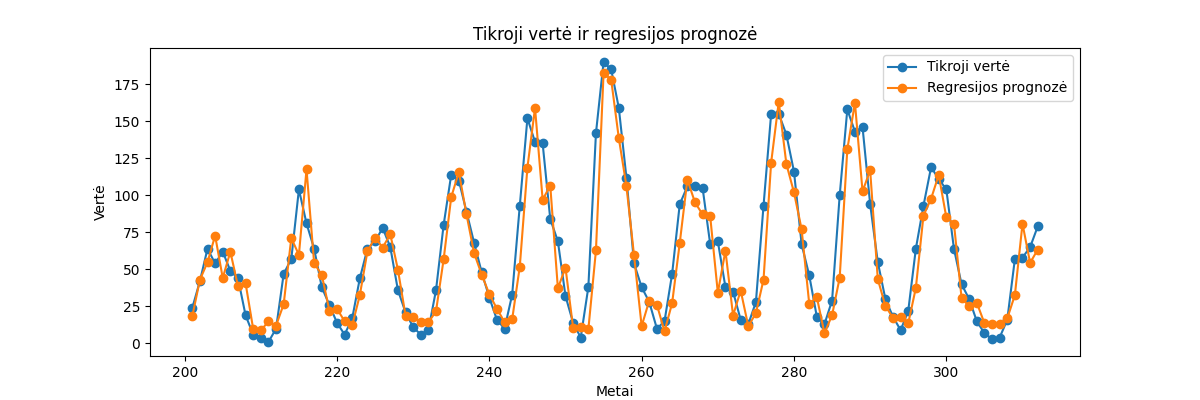

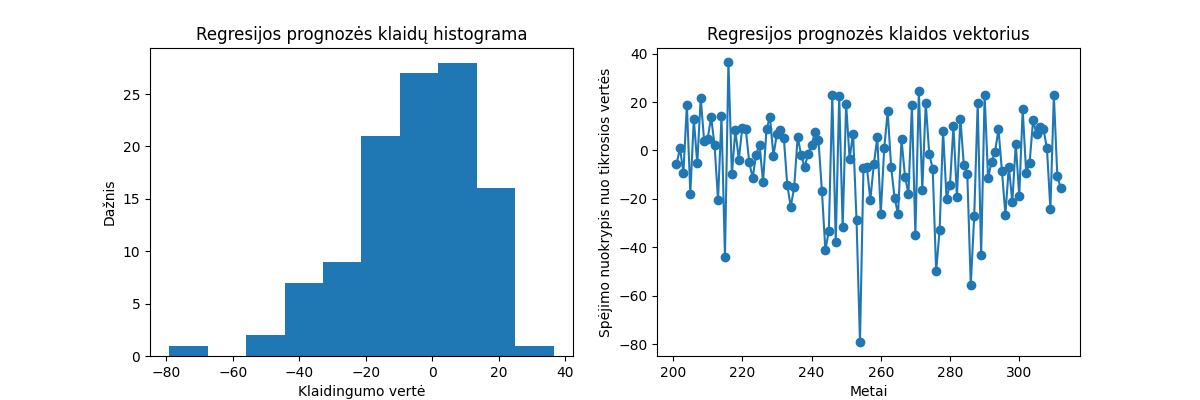

In [195]:
T1 = Pv['P1'] * -0.6774 + Pv['P2'] * 1.3723 + 13.4433

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
ax.plot(Tv.index, Tv, marker='o', label="Tikroji vertė")
ax.plot(Tv.index, T1, marker='o', label="Regresijos prognozė")
ax.set_xlabel('Metai')
ax.set_ylabel('Vertė')
ax.set_title('Tikroji vertė ir regresijos prognozė')
ax.legend(loc='best')

plt.legend(loc='best')
plt.show()

Terr = T1 - T
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax[0].hist(Terr)
ax[0].set_xlabel('Klaidingumo vertė')
ax[0].set_ylabel('Dažnis')
ax[0].set_title('Regresijos prognozės klaidų histograma')

ax[1].plot(range(1, len(Terr) + 1), Terr, marker='o')
ax[1].set_xlabel('Metai')
ax[1].set_ylabel('Spėjimo nuokrypis nuo tikrosios vertės')
ax[1].set_title('Regresijos prognozės klaidos vektorius')
plt.show()


Weights [b, w1, w2]:
[ 0.48029348 -0.58233066  1.46530449]
Min MSE (training):
277.2833723789226


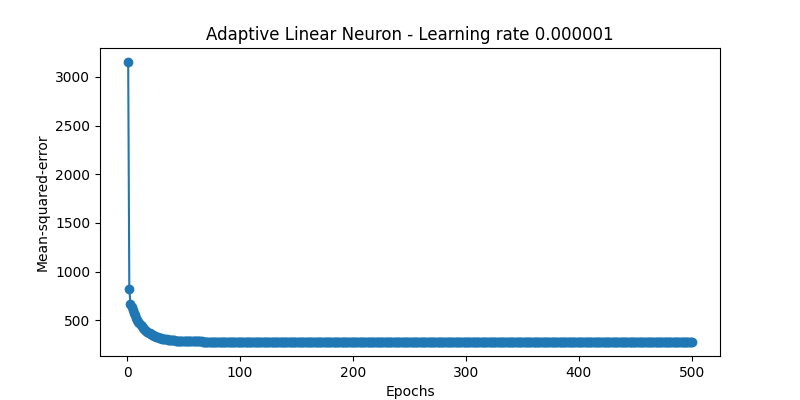

In [196]:
import numpy as np

class AdaptiveLinearNeuron(object):
   def __init__(self, rate = 0.01, niter = 10):
      self.rate = rate
      self.niter = niter

   def fit(self, X, y):
      """Fit training data
      X : Training vectors, X.shape : [#samples, #features]
      y : Target values, y.shape : [#samples]
      """

      # weights
      self.weight = np.zeros(1 + X.shape[1])

      # Number of misclassifications
      self.errors = []

      # Cost function
      self.cost = []

      for i in range(self.niter):
         output = self.net_input(X)
         errors = y - output
         self.weight[1:] += self.rate * X.T.dot(errors)
         self.weight[0] += self.rate * errors.sum()
         cost = (errors**2).sum() / len(errors)
         self.cost.append(cost)
      return self

   def net_input(self, X):
      """Calculate net input"""
      return np.dot(X, self.weight[1:]) + self.weight[0]

   def activation(self, X):
      """Compute linear activation"""
      return self.net_input(X)

   def predict(self, X):
      """Return class label after unit step"""
      return np.where(self.activation(X) >= 0.0, 1, -1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# learning rate = 0.000001
aln1 = AdaptiveLinearNeuron(0.000001, 500).fit(Pu,Tu)

ax.plot(range(1, len(aln1.cost) + 1), aln1.cost, marker='o')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean-squared-error')
ax.set_title('Adaptive Linear Neuron - Learning rate 0.000001')

print("Weights [b, w1, w2]:")
print(aln1.weight)
print("Min MSE (training):")
print(min(aln1.cost))

plt.show()

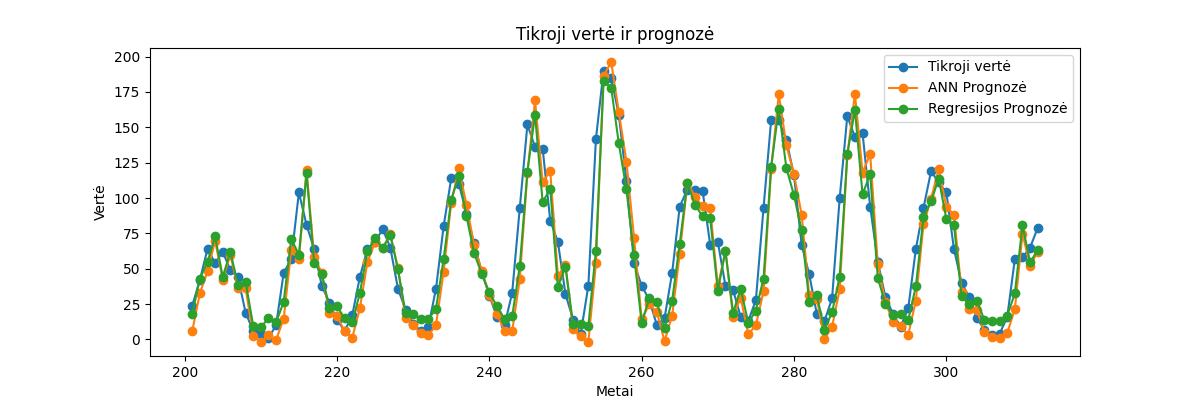

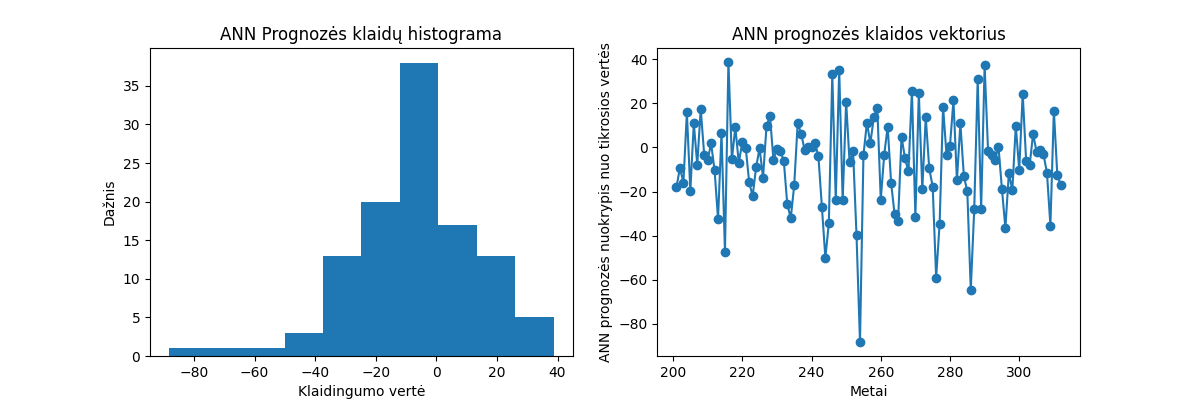

In [197]:
%matplotlib widget

Tr = Pv['P1'] * -0.6774 + Pv['P2'] * 1.3723 + 13.4433
Tann = Pv['P1'] * -0.58233066 + Pv['P2'] * 1.46530449 + 0.48029348

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
ax.plot(Tv.index, Tv, marker='o', label="Tikroji vertė")
ax.plot(Tv.index, Tann, marker='o', label="ANN Prognozė")
ax.plot(Tv.index, Tr, marker='o', label="Regresijos Prognozė")
ax.set_xlabel('Metai')
ax.set_ylabel('Vertė')
ax.set_title('Tikroji vertė ir prognozė')
ax.legend(loc='best')

plt.legend(loc='best')
plt.show()

Terr = Tann - T
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax[0].hist(Terr)
ax[0].set_xlabel('Klaidingumo vertė')
ax[0].set_ylabel('Dažnis')
ax[0].set_title('ANN Prognozės klaidų histograma')

ax[1].plot(range(1, len(Terr) + 1), Terr, marker='o')
ax[1].set_xlabel('Metai')
ax[1].set_ylabel('ANN prognozės nuokrypis nuo tikrosios vertės')
ax[1].set_title('ANN prognozės klaidos vektorius')
plt.show()

C:\Users\karol\AppData\Local\Temp\ipykernel_36988\1475788403.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


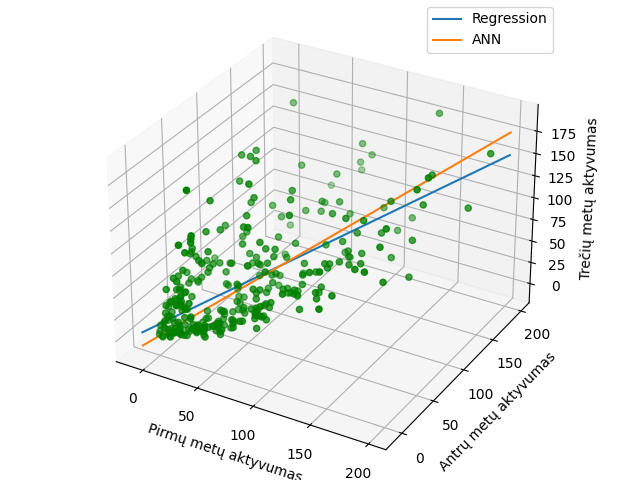

In [198]:


fig = plt.figure()
ax = Axes3D(fig)

plot = ax.scatter(P['P1'],P['P2'],T,color='green')

ax.set_title("Saulės dėmės")
ax.set_xlabel('Pirmų metų aktyvumas')
ax.set_ylabel('Antrų metų aktyvumas')
ax.set_zlabel('Trečių metų aktyvumas')

x_vals = np.array(ax.get_xlim())
y_vals = np.array(ax.get_ylim())
ax.plot(x_vals,y_vals,x_vals*-0.6774 + y_vals*1.3723 + 13.4433,label="Regression")
ax.plot(x_vals,y_vals,x_vals*-0.56811268 + y_vals*1.45656694 + 0.10245695, label="ANN")
plt.legend(loc='best')
plt.show()